In [1]:
import torch
import lib.utils.bookkeeping as bookkeeping
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import lib.models.models as models
import lib.models.model_utils as model_utils
import lib.datasets.datasets as datasets
import lib.datasets.dataset_utils as dataset_utils
import lib.losses.losses as losses
import lib.losses.losses_utils as losses_utils
import lib.training.training as training
import lib.training.training_utils as training_utils
import lib.optimizers.optimizers as optimizers
import lib.optimizers.optimizers_utils as optimizers_utils
import lib.loggers.loggers as loggers
import lib.loggers.logger_utils as logger_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils
import os
from lib.datasets.datasets import create_train_discrete_mnist_dataloader
from ruamel.yaml.scalarfloat import ScalarFloat

2023-10-31 09:41:04.558618: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# creating paths
path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-10-30' # 2023-10-30 'Hollow-2023-10-29'
config_name = 'config_001_maze.yaml' # 'config_001_maze.yaml' 'config_001_rate001.yaml'
model_name = 'model_5999_maze.pt' # 'model_55999_rate001.pt' 'model_5999_maze.pt'

config_path = os.path.join(path, date, config_name)
checkpoint_path = os.path.join(path, date, model_name)

In [3]:
# creating models
cfg = bookkeeping.load_config(config_path)
print(type(cfg.sampler.corrector_entry_time))
cfg.sampler.name = 'ExactSampling' #'ExactSampling' # LBJFSampling
cfg.logit_type = 'reverse_prob'
#cfg.sampler.corrector_entry_time = float(cfg.sampler.corrector_entry_time)
#cfg.sampler.corrector_entry_time = ScalarFloat(0.1)
cfg.sampler.num_steps = 10
cfg.sampler.is_ordinal = True

print(cfg)
device = torch.device(cfg.device)

model = model_utils.create_model(cfg, device)
print("number of parameters: ", sum([p.numel() for p in model.parameters()]))

#modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
#model.load_state_dict(modified_model_state)
#optimizer = optimizers_utils.get_optimizer(model.parameters(), cfg)
optimizer = torch.optim.Adam(model.parameters(), cfg.optimizer.lr)

sampler = sampling_utils.get_sampler(cfg)

state = {"model": model, "optimizer": optimizer, "n_iter": 0}
state = bookkeeping.load_state(state, checkpoint_path)
state['model'].eval()

<class 'ruamel.yaml.scalarfloat.ScalarFloat'>
attention_dropout_rate: !!python/object/new:ruamel.yaml.scalarfloat.ScalarFloat
  args:
  - 0.1
  state:
    _e_sign: null
    _e_width: null
    _exp: null
    _m_lead0: 1
    _m_sign: false
    _prec: 1
    _underscore: null
    _width: 3
bidir_readout: res_concat
ce_coeff: 1
concat_dim: 900
data:
  S: 2
  batch_size: 32
  image_size: 30
  shape: !!python/object/new:ruamel.yaml.comments.CommentedSeq
    listitems:
    - 1
    - 30
    - 30
    state:
      _yaml_format: !!python/object/new:ruamel.yaml.comments.Format
        state: !!python/tuple
        - null
        - _flow_style: false
      _yaml_line_col: !!python/object:ruamel.yaml.comments.LineCol
        col: 2
        data:
          0:
          - 9
          - 4
          1:
          - 10
          - 4
          2:
          - 11
          - 4
        line: 9
  shuffle: true
  use_augm: false
device: cpu
distributed: false
dropout_rate: !!python/object/new:ruamel.yaml.scalarf

In [4]:
n_samples = 16
samples = sampler.sample(model, n_samples, 10)
samples = samples.reshape(n_samples, 1, cfg.data.image_size, cfg.data.image_size)

0it [00:00, ?it/s]/Users/paulheller/PythonRepositories/Master-Thesis/diffvenv/lib/python3.10/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(
10it [00:59,  5.93s/it]


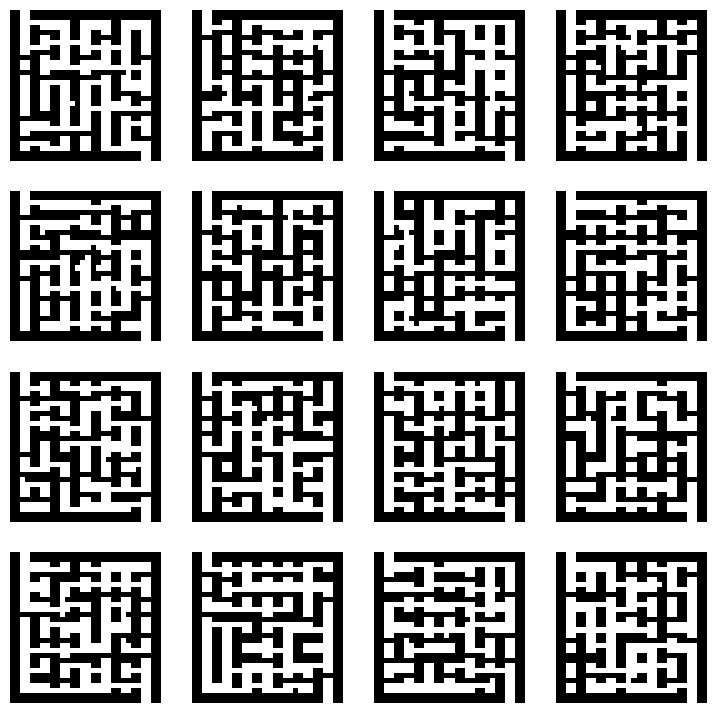

In [5]:
saving_train_path = os.path.join(cfg.saving.sample_plot_path, f"eval_{cfg.loss.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
fig = plt.figure(figsize=(9, 9))  
for i in range(n_samples):
    plt.subplot(int(np.sqrt(n_samples)), int(np.sqrt(n_samples)), 1 + i)
    plt.axis("off")
    plt.imshow(np.transpose(samples[i, ...], (1,2,0)), cmap="gray")


plt.savefig(saving_train_path)
plt.show()
plt.close()